## How to keep a Telco Customer

by Chloe Whitaker 2021-11-29

### Project Introduction

#### Project Goal

#### Project Description

#### Initial Questions

1. What month are customers most likely to churn in?    
2. Are customers with a certain service type more or less likely to churn? 
    - Specifically are customers with fiber more likely to churn? 
3. Do the customers that churn have a higher monthly cost than those that do not churn? 
    - Do the customers that churn have a higher monthly cost and a certain service type? 
4. Do the customers that churn use paperless billing more than those who don't?

#### Data Dictionary

#### Imports Necessary for this project

In [144]:
import acquire_telco
import prepare_telco

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import math

from pydataset import data

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

### Aquire the Telco Data

We will aquire the telco data from the Codeup SQL database using a function stored in acquire_telco.py.

In [5]:
# import acquire_telco.py
import acquire_telco

In [6]:
# acquire
df = acquire_telco.new_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


### Wrangle the Telco Data

Here we will prepare the data using functions stored in prepare_telco.py. 
We are going to use this data to develop a model, therefore we need to make sure there are no incompatible datatypes, and we are left with only clean columns that are useful. We will also need to split the data into train, validate, test so that we can test the accuracy of our model. 

We will run the clean_split_telco_data function that runs both the wrangle_telco and the train_validate_test_split functions. 

The wrangle_telco data will do the following:
- remove duplicates
- drop whitespaces
- drop the columns that don't seem useful: 'payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id', and 'gender'
- converts 'total_charges' from and object to a float
- converts the binary categorical variables to numeric: 'tenure', 'churn', 'partner', 'dependents', 'paperless_billing', 'phone_service', 'multiple_lines', 'online_security', 'streaming_movies', 'streaming_tv', 'online_backup', 'device_protection', 'tech_support', 'is_autopay'
- gets dummies from non-binary object varibales 
- concatenate dummy dataframe to original 
- returns the cleaned df

The train_validate_test_split function will do the following: 

- takes in a dataframe (df) and returns 3 dfs (train, validate, and test) split 20%, 24%, 56% respectively 
- takes in a random seed for replicating results

In [7]:
# import prepare_telco.py
import prepare_telco

In [8]:
# run functions from prepare_teco.py to prepare and split the data
train, validate, test = prepare_telco.clean_split_telco_data(df)

In [9]:
train.shape

(3937, 30)

In [10]:
validate.shape

(1688, 30)

In [11]:
test.shape

(1407, 30)

In [12]:
# verify the df we brought in is what we want
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,contract_type_month_to_month,contract_type_one_year,contract_type_two_year,internet_service_type_DSL,internet_service_type_fiber_optic,internet_service_type_None,payment_type_bank_transfer_auto,payment_type_credit_card_auto,payment_type_electronic_check,payment_type_mailed_check
6096,0,1,0,70,1,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
1603,0,1,1,15,1,0,0,1,1,1,...,1,0,0,1,0,0,0,0,0,1
5350,1,1,0,52,1,1,1,1,1,0,...,1,0,0,0,1,0,0,0,1,0
2068,0,0,0,39,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
6366,0,1,0,32,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [13]:
# check that datatypes are all compatible for modeling
train.dtypes

senior_citizen                         int64
partner                                int64
dependents                             int64
tenure                                 int64
phone_service                          int64
multiple_lines                         int64
online_security                        int64
online_backup                          int64
device_protection                      int64
tech_support                           int64
streaming_tv                           int64
streaming_movies                       int64
paperless_billing                      int64
monthly_charges                      float64
total_charges                        float64
churn                                  int64
contract_type                         object
internet_service_type                 object
payment_type                          object
is_autopay                              bool
contract_type_month_to_month           uint8
contract_type_one_year                 uint8
contract_t

Before we get to the modeling stage, we will drop the three columns that are 'object' datatypes. This type is not compatible with modeling but will be useful in the exploritory stage. 
Since we have created dummies from these columns we will not need them anymore. 

### Explore the Telco Data

Here we will explore the telco data to find the key drivers of customer churn. 

We will ask some initial questions and and answer thoes questions through visuals, statistics, or both. 

To get an idea of what kind of question might relevent to ask we can look at the makup of each column in the Telco train data:

In [103]:
# for each column in train, print the value counts of each variable
for col in train:
    print(col)
    print(train[col].value_counts())

senior_citizen
0    3290
1     647
Name: senior_citizen, dtype: int64
partner
0    2033
1    1904
Name: partner, dtype: int64
dependents
0    2764
1    1173
Name: dependents, dtype: int64
tenure
1     350
72    202
2     133
3     121
71    107
4     103
5      80
7      75
70     70
8      68
11     66
68     65
9      63
12     63
10     62
13     59
6      59
69     57
67     53
23     53
15     52
24     51
64     50
14     50
18     49
30     48
56     47
61     46
22     45
60     44
62     44
52     44
41     44
16     43
29     43
65     42
35     42
66     41
53     41
19     41
26     41
33     41
46     40
32     40
51     40
27     39
40     39
17     38
55     38
54     37
48     37
50     36
34     36
63     36
57     36
37     36
39     35
43     35
38     35
28     34
21     34
49     34
25     34
47     34
59     33
20     32
31     31
58     31
45     30
36     28
42     26
44     25
Name: tenure, dtype: int64
phone_service
1    3548
0     389
Name: phone_service, dty

Before we can start to run stat tests and create visuals, we need to create variables to make things simpler.

In [62]:
# We know know telco wants to focus on the cause of m2m churn so we will start there
m2m_churn = train[['contract_type']][(train['churn'] == 1)]
m2m_no_churn = train[['contract_type']][(train['churn'] == 0)]

In [137]:
internet_churn = train[['internet_service_type']][(train['churn'] == 1)]
internet_no_churn = train[['internet_service_type']][(train['churn'] == 0)]

In [19]:
fiber_churn = train[['internet_service_type_fiber_optic']][(train['churn'] == 1)]
fiber_no_churn = train[['internet_service_type_fiber_optic']][(train['churn'] == 0)]

In [20]:
tenure_churn = train[['tenure']][(train['churn'] == 1)]
tenure_no_churn = train[['tenure']][(train['churn'] == 0)]

In [84]:
m2m_tenure = train[['tenure']][(train['contract_type'] == 'Month-to-month')]

In [155]:
paperless_b_churn = train[['paperless_billing']][(train['churn'] == 1)]
paperless_b_no_churn = train[['paperless_billing']][(train['churn'] == 0)]

#### The problem: Churn

Overall churn at Telco is 26.7%

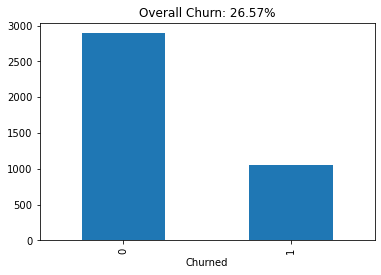

In [125]:
train.churn.value_counts().sort_index().plot.bar()
churn_rate = train.churn.mean()
plt.title(f"Overall Churn: {churn_rate:.2%}")
plt.xlabel('Churned');

We will be looking specifically at the month-to-month (m2m) contracts since that's where most of the churn takes place, and that is where Telco would like this project to focus. 

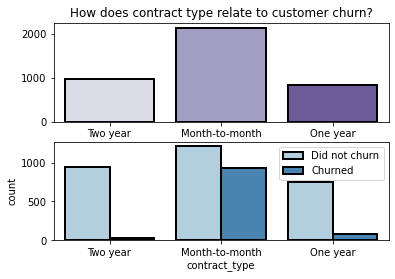

In [24]:
plt.subplot(211)

sns.countplot(x = 'contract_type', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How does contract type relate to customer churn?')
plt.xlabel('')
plt.ylabel('')

plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'contract_type', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Did not churn', 'Churned'])

plt.show()


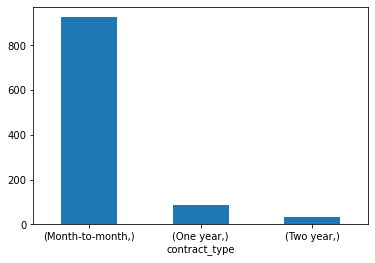

In [26]:
# m2m churn compared to the other contract types
m2m_churn.value_counts().plot.bar(rot=0);

Month-2-month churn is 26.57%

1. What month are customers most likely to churn in?  

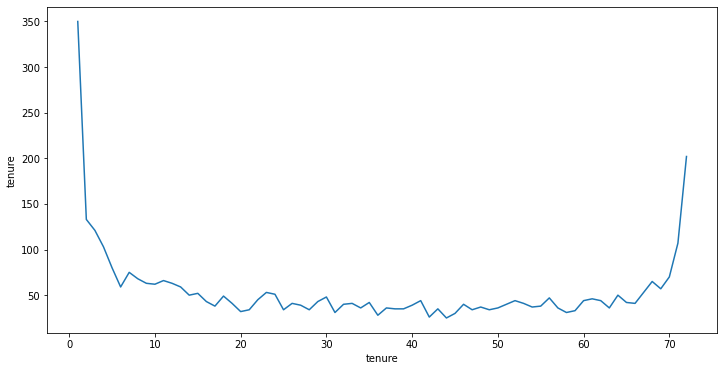

In [93]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=train.groupby(by='tenure')['tenure'].count().index, y=train.groupby(by='tenure')['tenure'].count());


In [83]:
avg_churn = train.groupby('churn').tenure.mean()

avg_churn.head()

churn
0    37.583535
1    18.471319
Name: tenure, dtype: float64

After the first month, the amount of customers that stay decrease significantly, with the average number of months a churning customers stays being 18. 

2. Are customers with a certain service type more or less likely to churn
  - Specifically are customers with fiber more likely to churn? 

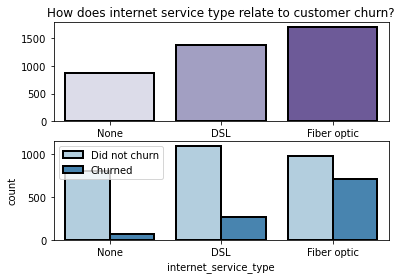

In [27]:
plt.subplot(211)

sns.countplot(x = 'internet_service_type', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How does internet service type relate to customer churn?')
plt.xlabel('')
plt.ylabel('')

plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'internet_service_type', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Did not churn', 'Churned'])

plt.show()


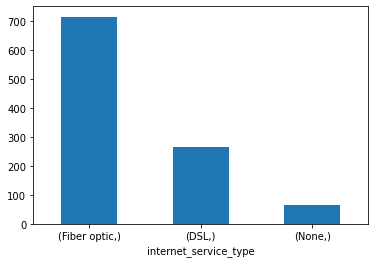

In [21]:
internet_churn.value_counts().plot.bar(rot=0);

Through these visuals we can see that fiber customers are more likely to churn than DSL and those without internet. 

Now we will run a Chi2 statistical test to see whether there is a correlation between fiber customers and churn. 

In [128]:
# set alpha to 0.05 to ensure 95% confidence
a = 0.05

Null Hypothesis: A customer churning and having fiber optic internet are independent. 

Alt Hypothesis: A customer churning and having fiber optic internet are dependent.

In [135]:
internet_churn.value_counts()

internet_service_type
Fiber optic              716
DSL                      266
None                      64
dtype: int64

In [139]:
266 + 64

330

In [138]:
internet_no_churn.value_counts()

internet_service_type
DSL                      1102
Fiber optic               982
None                      807
dtype: int64

In [140]:
1102 + 807

1909

In [142]:
observed = pd.DataFrame([[716, 330], [982, 1909]])
observed.index = ['Churn', 'No Churn']
observed.columns = ['Fiber', 'No Fiber']
observed


,Fiber,No Fiber
Churn,716,330
No Churn,982,1909


In [145]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [146]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[ 716  330]
 [ 982 1909]]
---
Expected

[[ 451  594]
 [1246 1644]]
---

chi^2 = 370.9722
p     = 0.0000


In [147]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")

We reject the null


We reject the null hypothesis that a customer churning and having fiber optic internet are independent. 

3. Do the customers that churn have a higher monthly cost than those that do not churn? 

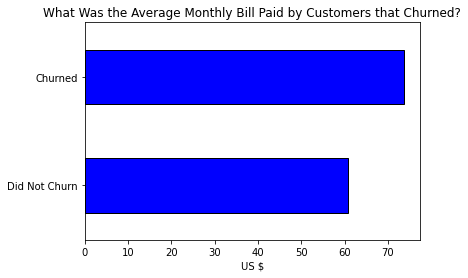

In [130]:
# Plot groupby churn to see average monthly charges comparison
train.groupby('churn').monthly_charges.mean().plot(kind='barh', color='blue', ec='black')

plt.title('What Was the Average Monthly Bill Paid by Customers that Churned?')

locs, labels = plt.yticks()
plt.yticks(locs, ('Did Not Churn', 'Churned'))
plt.ylabel('')
plt.xlabel('US $')

plt.show()

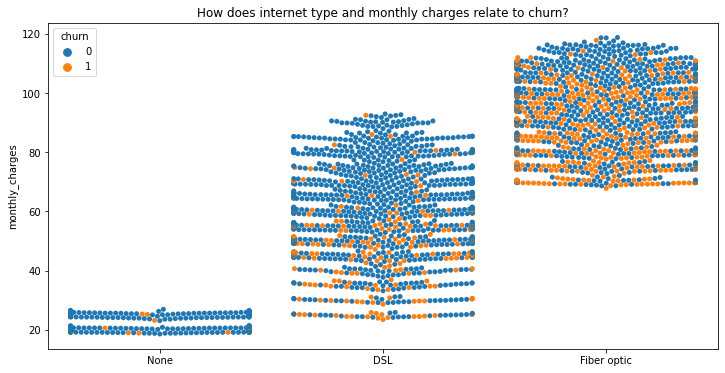

In [97]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='internet_service_type', y='monthly_charges', data=train , hue='churn'  )

plt.title('How does internet type and monthly charges relate to churn?')
plt.xlabel('')
plt.show()

 4. Do the customers that churn use paperless billing more than those who don't?

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

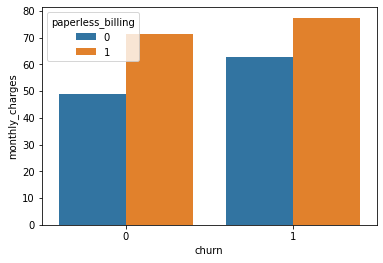

In [126]:
sns.barplot(x="churn", y="monthly_charges", data=train, ci=None, hue="paperless_billing")

Through this visual we can see that paperless billing customers are more likely to churn than not. 

Now we will run a Chi2 statistical test to see whether there is a correlation between paperless billing customers and churn. 

In [148]:
# set alpha to 0.05 to ensure 95% confidence
a = 0.05

Null Hypothesis: A customer churning and having paperless billing are independent. 

Alt Hypothesis: A customer churning and having paperless billing are dependent. 

In [157]:
paperless_b_churn.value_counts()

paperless_billing
1                    779
0                    267
dtype: int64

In [158]:
paperless_b_no_churn.value_counts()

paperless_billing
1                    1540
0                    1351
dtype: int64

In [159]:
observed = pd.DataFrame([[779, 267], [1540, 1315]])
observed.index = ['Churn', 'No Churn']
observed.columns = ['Paperless', 'Not Paperless']
observed


,Paperless,Not Paperless
Churn,779,267
No Churn,1540,1315


In [160]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [161]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[ 779  267]
 [1540 1315]]
---
Expected

[[ 621  424]
 [1697 1157]]
---

chi^2 = 133.0378
p     = 0.0000


In [162]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")

We reject the null


We reject the null hypothesis that a customer churning and having paperless billing are independent.

### Modeling to Predict Customer Churn

Before we build our models we need to define our X and Y variables and drop the three categorical features that are left. 

In [164]:
X_train = train.drop(columns=['contract_type', 'internet_service_type', 'payment_type'])
y_train = train[['churn']]

X_validate = validate.drop(columns=['contract_type', 'internet_service_type', 'payment_type'])
y_validate = validate[['churn']]

X_test = test.drop(columns=['contract_type', 'internet_service_type', 'payment_type'])
y_test = test[['churn']]


In [166]:
X_train.dtypes

senior_citizen                         int64
partner                                int64
dependents                             int64
tenure                                 int64
phone_service                          int64
multiple_lines                         int64
online_security                        int64
online_backup                          int64
device_protection                      int64
tech_support                           int64
streaming_tv                           int64
streaming_movies                       int64
paperless_billing                      int64
monthly_charges                      float64
total_charges                        float64
churn                                  int64
is_autopay                              bool
contract_type_month_to_month           uint8
contract_type_one_year                 uint8
contract_type_two_year                 uint8
internet_service_type_DSL              uint8
internet_service_type_fiber_optic      uint8
internet_s

#### Establishing the Baseline

#### Fit Three Different Models

#### Select the Best Model For the Project

### Project Conclusion 

#### Summary

#### Recommendations